### Final Pipeline

In [1]:
import numpy as np
import pandas as pd
import os, glob, gc
import scipy

import torch
from torch.utils.data import DataLoader, Dataset, random_split, Subset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision

import h5py
import pyarrow.parquet as pq
from tqdm.auto import tqdm
import seaborn as sns
import itertools
from astropy.stats import sigma_clip

import joblib  # for saving scalers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

pd.set_option('future.no_silent_downcasting', True)

import warnings
warnings.filterwarnings("ignore")

/home/arbiter/projects/Spectrum-recovery/.env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
dir_name = "/kaggle/input/ariel-data-challenge-2025/"
train_dir_name = "/kaggle/input/ariel-data-challenge-2025/test/"
model_path = "/kaggle/input/ariel-2d-enc-001/pytorch/default/2/best_checkpoint.pth"
meta_scaler = joblib.load("/kaggle/input/ariel-2d-enc-001/pytorch/default/2/meta_scaler.pkl")
y_scaler = joblib.load("/kaggle/input/ariel-2d-enc-001/pytorch/default/2/y_scaler.pkl")
depth_scaler_airs = joblib.load("/kaggle/input/ariel-2d-enc-001/pytorch/default/2/depth_scaler_airs.pkl")
depth_scaler_fgs = joblib.load("/kaggle/input/ariel-2d-enc-001/pytorch/default/2/depth_scaler_fgs.pkl")

is_train=False
adc_df = pd.read_csv(f"{dir_name}adc_info.csv")
train_df = pd.read_csv(f"{dir_name}train.csv", index_col="planet_id")
if is_train:
    star_info = pd.read_csv(os.path.join(dir_name, "train_star_info.csv"))
else:
    star_info = pd.read_csv(os.path.join(dir_name, "test_star_info.csv"))
star_info.set_index("planet_id", inplace=True)

In [ ]:
def adc_airs(signal, gain = float(adc_df["AIRS-CH0_adc_gain"].iloc[0]), offset = float(adc_df["AIRS-CH0_adc_offset"].iloc[0])):

    signal = signal.astype(np.float64)
    signal /= gain
    signal += offset

    return signal

def adc_fgs(signal, gain = float(adc_df["FGS1_adc_gain"].iloc[0]), offset = float(adc_df["FGS1_adc_offset"].iloc[0])):

    signal = signal.astype(np.float64)
    signal /= gain
    signal += offset

    return signal

def masking_dead_hot_torch(signal, dead, dark_mask_np):
    hot_mask = sigma_clip(dark_mask_np, sigma=5, maxiters=5).mask
    hot = torch.from_numpy(hot_mask).to(signal.device)

    hot  = hot.unsqueeze(0).expand(signal.shape[0], -1, -1)
    dead = dead.unsqueeze(0).expand(signal.shape[0], -1, -1)

    mask = hot | dead
    # If downstream code depends on np.ma, we should use NaN. I just don't like NaNs in my data.
    return signal.masked_fill(mask, 0.0)

def dark_current_sub_torch(signal, dead, dark, dt):
    dark = dark.masked_fill(dead, 0.0)
    dark = dark.unsqueeze(0).expand(signal.shape[0], -1, -1)
    dt   = dt.view(-1,1,1)
    return signal - dark * dt

def apply_lin_corr_torch(lin_corr, clean_signal):
    lin_corr = torch.flip(lin_corr, dims=[0])   # descending order
    out = torch.zeros_like(clean_signal)
    for coeff in lin_corr:
        out = out * clean_signal + coeff
    return out

def correct_flat_field_torch(flat, dead, signal):
    flat = flat.T
    dead = dead.T
    flat = flat.masked_fill(dead.bool(), 1.0)
    flat = flat.unsqueeze(0).expand(signal.shape[0], -1, -1)
    return signal / flat

def get_cds_torch(signal):
    if signal.dim() == 3:
        return signal[1::2] - signal[::2]
    elif signal.dim() == 4:
        return signal[:,1::2] - signal[:,::2]
    else:
        raise ValueError(f"Unsupported signal shape {signal.shape}")

def bin_obs_torch(binning, cds_signals):
    cds_transposed = cds_signals.permute(0, 1, 3, 2)  # match np.transpose(0,1,3,2)
    N, T, W, H = cds_transposed.shape
    T_new = T // binning
    cds_binned = cds_transposed[:, :T_new*binning] \
        .reshape(N, T_new, binning, W, H) \
        .sum(dim=2)
    return cds_binned

def get_index(files, chunk_size):
    index = []

    for file in files:
        file_name = file.split("/")[-1]   # getting the file name 
        # making sure we are working with AIRS parquet file for the star 
        if file_name.split('_')[0] == 'AIRS-CH0' and file_name.split('_')[1] == 'signal' and file_name.split('_')[2] == '0.parquet':
            file_index = os.path.basename(os.path.dirname(file))  # going one directory up and extracting the basename for the path
            index.append(int(file_index)) 
    index = np.array(index)   
    index = np.sort(index)    # sorting the indices 

    index=np.array_split(index, len(index)//chunk_size)   # dividing the data indices into chunks 
    
    return index

### Helpers for Pipeline

def read_parquet_array(path, shape, cut=None):
    """Efficient parquet read to numpy (float32)."""
    table = pq.read_table(path, memory_map=True)
    arr = table.to_pandas().to_numpy(dtype=DTYPE, copy=False).reshape(shape)
    if cut is not None:
        a, b = cut
        arr = arr[..., a:b]
    return arr


def load_calibration(base_dir, inst, obs_idx=0, cut=None):
    """
    Load calibration arrays for AIRS or FGS with correct shapes.
    Handles multiple data points for same planets (110 such training samples).
    
    Args:
        base_dir: planet folder path
        inst: "AIRS-CH0" or "FGS1"
        obs_idx: which observation (0, 1, ...)
        cut: wavelength cut tuple for AIRS
    """
    calib = {}
    calib_dir = os.path.join(base_dir, f"{inst}_calibration_{obs_idx}")
    
    if inst.startswith("AIRS"):
        calib["flat"]  = read_parquet_array(os.path.join(calib_dir, "flat.parquet"),
                                            (32, 356), cut)
        calib["dark"]  = read_parquet_array(os.path.join(calib_dir, "dark.parquet"),
                                            (32, 356), cut)
        calib["dead"]  = read_parquet_array(os.path.join(calib_dir, "dead.parquet"),
                                            (32, 356), cut)
        calib["linear_corr"] = read_parquet_array(os.path.join(calib_dir, "linear_corr.parquet"),
                                                  (6, 32, 356), cut)
    elif inst.startswith("FGS"):
        calib["flat"]  = read_parquet_array(os.path.join(calib_dir, "flat.parquet"),
                                            (32, 32))
        calib["dark"]  = read_parquet_array(os.path.join(calib_dir, "dark.parquet"),
                                            (32, 32))
        calib["dead"]  = read_parquet_array(os.path.join(calib_dir, "dead.parquet"),
                                            (32, 32))
        calib["linear_corr"] = read_parquet_array(os.path.join(calib_dir, "linear_corr.parquet"),
                                                  (6, 32, 32))
    else:
        raise ValueError(f"Unknown instrument {inst}")
    
    return calib


def save_hdf5(path, name, data, meta=None, pid=None):
    with h5py.File(path, "w") as f:
        f.create_dataset(name, data=data, compression="gzip")
        if meta is not None:
            f.create_dataset("meta", data=meta)
        if pid is not None:
            f.create_dataset("planet_id", data=np.array(pid, dtype=np.int64))

### Physical Processing

In [3]:
# CONFIG
DTYPE = np.float32
CUT_INF, CUT_SUP = 39, 321
L = CUT_SUP - CUT_INF

DO_MASK = True
DO_THE_NL_CORR = True
DO_DARK = True
DO_FLAT = True
TIME_BINNING = True

def run_physical_processing(DTYPE, CUT_INF, CUT_SUP, L, DO_MASK, DO_THE_NL_CORR, DO_DARK, DO_FLAT, TIME_BINNING, is_train=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if is_train:
        sample_dirs = glob.glob(os.path.join(dir_name, "train/*"))
    else:
        sample_dirs = glob.glob(os.path.join(dir_name, "test/*"))
    sample_dirs = [d for d in sample_dirs if os.path.isdir(d)]
    print("Found samples:", len(sample_dirs))
    
    # Axis info (for AIRS integration times)
    axis_info = pd.read_parquet(os.path.join(dir_name, 'axis_info.parquet'), engine="pyarrow")
    dt_airs_global_np = axis_info["AIRS-CH0-integration_time"].dropna().to_numpy(dtype=DTYPE)
    dt_airs_global_np[1::2] += DTYPE(0.1)
    dt_airs_global = torch.tensor(dt_airs_global_np, dtype=torch.float32, device=device)
    
    # Output dirs
    airs_out_dir = os.path.join("/kaggle/working/train/airs")
    fgs_out_dir  = os.path.join("/kaggle/working/train/fgs")
    os.makedirs(airs_out_dir, exist_ok=True)
    os.makedirs(fgs_out_dir, exist_ok=True)
    
    # --------------------
    # MAIN LOOP (multi-obs support)
    # --------------------
    for base_dir in tqdm(sample_dirs, desc="Processing samples"):
        pid = os.path.basename(base_dir)
        meta = star_info.loc[int(pid)].to_numpy(dtype=np.float32)
    
        # --- AIRS ---
        airs_files = sorted(glob.glob(os.path.join(base_dir, "AIRS-CH0_signal_*.parquet")))
        for obs_idx, f in enumerate(airs_files):
            signal_np = read_parquet_array(f, (11250, 32, 356))
            signal = torch.tensor(
                adc_airs(signal_np)[..., CUT_INF:CUT_SUP],
                dtype=torch.float32, device=device
            )
    
            calib_airs = load_calibration(base_dir, "AIRS-CH0", obs_idx, cut=(CUT_INF, CUT_SUP))
            dead_airs  = torch.tensor(calib_airs["dead"], dtype=torch.bool, device=device)
            dark_airs  = torch.tensor(calib_airs["dark"], dtype=torch.float32, device=device)
            lin_corr_a = torch.tensor(calib_airs["linear_corr"], dtype=torch.float32, device=device)
    
            if DO_MASK:
                signal = masking_dead_hot_torch(signal, dead_airs, calib_airs["dark"])
            if DO_THE_NL_CORR:
                signal = apply_lin_corr_torch(lin_corr_a, signal)
            if DO_DARK:
                signal = dark_current_sub_torch(signal, dead_airs, dark_airs, dt_airs_global)
    
            AIRS_cds = get_cds_torch(signal.unsqueeze(0))
            if TIME_BINNING:
                AIRS_cds = bin_obs_torch(30, AIRS_cds)
    
            flat_airs = read_parquet_array(
                os.path.join(base_dir, f"AIRS-CH0_calibration_{obs_idx}/flat.parquet"),
                (32, 356), cut=(CUT_INF, CUT_SUP)
            )
            AIRS_cds = correct_flat_field_torch(
                torch.tensor(flat_airs, dtype=torch.float32, device=device),
                dead_airs,
                AIRS_cds[0]
            )
    
            save_hdf5(
                os.path.join(airs_out_dir, f"AIRS_clean_{pid}_{obs_idx}.h5"),
                "AIRS",
                AIRS_cds.cpu().numpy(),
                meta=meta,
                pid=pid
            )
    
            del signal, AIRS_cds
            torch.cuda.empty_cache()
            gc.collect()
    
        # --- FGS ---
        fgs_files = sorted(glob.glob(os.path.join(base_dir, "FGS1_signal_*.parquet")))
        for obs_idx, f in enumerate(fgs_files):
            fgs_np = read_parquet_array(f, (135000, 32, 32))
            fgs_signal = torch.tensor(adc_fgs(fgs_np), dtype=torch.float32, device=device)
    
            dt_fgs1 = torch.full((len(fgs_signal),), 0.1, dtype=torch.float32, device=device)
            dt_fgs1[1::2] += 0.1
    
            calib_fgs = load_calibration(base_dir, "FGS1", obs_idx)
            dead_fgs  = torch.tensor(calib_fgs["dead"], dtype=torch.bool, device=device)
            dark_fgs  = torch.tensor(calib_fgs["dark"], dtype=torch.float32, device=device)
            lin_corr_f = torch.tensor(calib_fgs["linear_corr"], dtype=torch.float32, device=device)
    
            if DO_MASK:
                fgs_signal = masking_dead_hot_torch(fgs_signal, dead_fgs, calib_fgs["dark"])
            if DO_THE_NL_CORR:
                fgs_signal = apply_lin_corr_torch(lin_corr_f, fgs_signal)
            if DO_DARK:
                fgs_signal = dark_current_sub_torch(fgs_signal, dead_fgs, dark_fgs, dt_fgs1)
    
            FGS1_cds = get_cds_torch(fgs_signal.unsqueeze(0))
            if TIME_BINNING:
                FGS1_cds = bin_obs_torch(30*12, FGS1_cds)
    
            flat_fgs = read_parquet_array(
                os.path.join(base_dir, f"FGS1_calibration_{obs_idx}/flat.parquet"),
                (32, 32)
            )
            FGS1_cds = correct_flat_field_torch(
                torch.tensor(flat_fgs, dtype=torch.float32, device=device),
                dead_fgs,
                FGS1_cds[0]
            )
    
            save_hdf5(
                os.path.join(fgs_out_dir, f"FGS1_clean_{pid}_{obs_idx}.h5"),
                "FGS",
                FGS1_cds.cpu().numpy(),
                meta=meta,
                pid=pid
            )
    
            del fgs_signal, FGS1_cds
            torch.cuda.empty_cache()
            gc.collect()

In [ ]:
run_physical_processing(DTYPE, CUT_INF, CUT_SUP, L, DO_MASK, DO_THE_NL_CORR, DO_DARK, DO_FLAT, TIME_BINNING, is_train=False)

In [4]:
def consolidate_joint_h5(airs_folder, fgs_folder, output_file, star_info_df):
    airs_files = sorted(glob.glob(os.path.join(airs_folder, "*.h5")))
    fgs_files  = sorted(glob.glob(os.path.join(fgs_folder, "*.h5")))
    assert len(airs_files) == len(fgs_files), "Mismatch AIRS/FGS counts"

    planet_ids = [int(os.path.basename(f).split("_")[2]) for f in airs_files]

    with h5py.File(airs_files[0], "r") as f:
        airs_shape = f["AIRS"].shape
    with h5py.File(fgs_files[0], "r") as f:
        fgs_shape = f["FGS"].shape

    # Collect metadata
    all_meta = [star_info_df.loc[pid].to_numpy(dtype=np.float32) for pid in planet_ids]
    all_meta = np.stack(all_meta, axis=0)

    with h5py.File(output_file, "w") as out_f:
        out_f.create_dataset("AIRS", shape=(len(airs_files), *airs_shape),
                             dtype=np.float32, chunks=(1, *airs_shape), compression="gzip")
        out_f.create_dataset("FGS",  shape=(len(fgs_files), *fgs_shape),
                             dtype=np.float32, chunks=(1, *fgs_shape), compression="gzip")
        out_f.create_dataset("meta", data=all_meta, dtype=np.float32, compression="gzip")
        out_f.create_dataset("planet_id", data=np.array(planet_ids, dtype=np.int64))

        for i, (af, ff) in enumerate(tqdm(zip(airs_files, fgs_files), total=len(airs_files),
                                          desc="Consolidating AIRS+FGS")):
            with h5py.File(af, "r") as fa, h5py.File(ff, "r") as ff:
                out_f["AIRS"][i] = fa["AIRS"][:]
                out_f["FGS"][i]  = ff["FGS"][:]

In [ ]:
airs_folder = '/kaggle/working/train/airs'
fgs_folder = '/kaggle/working/train/fgs'
output_file = 'output.h5'

consolidate_joint_h5(airs_folder, fgs_folder, output_file, star_info)

In [5]:
def process_and_save_signals(airs_signal, fgs_signal, output_file):
    """
    Process AIRS and FGS signals by subtracting foreground/background
    and save to HDF5 file.
    
    Parameters
    ----------
    airs_signal : np.ndarray
        Raw AIRS data (planet, time, wavelength, spatial axis).
    fgs_signal : np.ndarray
        Raw FGS data (planet, time, H, W).
    output_file : str
        Path to save processed signals (.h5 file).
    """

    def subtract_foreground(signal, sensor):
        if sensor == "AIRS":
            # background = left + right pixels
            signal_bg = np.nanmean(
                np.concatenate([signal[:, :, :, 0:8], signal[:, :, :, 24:32]], axis=-1), 
                axis=-1
            )   # (planet, time, wavelength)
            
            signal_bg[np.isnan(signal_bg)] = 0.0
            
            # foreground = central PSF pixels
            signal = signal[:, :, :, 8:24]
            signal = np.nanmean(signal, axis=-1)   # collapse spatial axis
            
            # subtract background
            signal -= signal_bg  # shape: (planet, time, wavelength)

        elif sensor == "FGS":
            # crop central patch of PSF
            signal = signal[:, :, 10:22, 10:22]  
            signal = signal.reshape(signal.shape[0], signal.shape[1], -1)  
            # (planet, time, pixels)

        return signal

    # --- Process both sensors ---
    airs_processed = subtract_foreground(airs_signal, sensor="AIRS")
    fgs_processed = subtract_foreground(fgs_signal, sensor="FGS")

    # --- Save results ---
    with h5py.File(output_file, "w") as f:
        f.create_dataset("AIRS", data=np.array(airs_processed), compression="gzip")
        f.create_dataset("FGS", data=np.array(fgs_processed), compression="gzip")

    print(f"Processed signals saved to {output_file}")

In [ ]:
output_file = "/kaggle/working/processed_file.h5"

with h5py.File("/kaggle/working/output.h5") as data_file:
    airs_train = np.array(data_file["AIRS"])
    fgs_train  = np.array(data_file["FGS"])

process_and_save_signals(airs_train, fgs_train, output_file)

In [6]:
def augment_h5_with_pid_meta(src_file, dest_file, airs_folder, star_info_df):
    """
    Read src_file (read-only), write dest_file with everything copied plus:
      - 'planet_id' (int64)
      - 'meta' (float32, from star_info_df indexed by planet_id)
    planet_ids are derived EXACTLY like before:
        int(os.path.basename(f).split("_")[2]) for f in sorted(AIRS files)
    """
    # 1) derive planet_ids from sorted AIRS filenames
    airs_files = sorted(glob.glob(os.path.join(airs_folder, "*.h5")))
    if not airs_files:
        raise FileNotFoundError(f"No .h5 files found in {airs_folder}")
    planet_ids = np.array([int(os.path.basename(f).split("_")[2]) for f in airs_files], dtype=np.int64)

    # 2) build meta in that order
    meta = np.stack([star_info_df.loc[int(pid)].to_numpy(dtype=np.float32) for pid in planet_ids], axis=0)

    # 3) copy src -> dest and add datasets
    os.makedirs(os.path.dirname(dest_file) or ".", exist_ok=True)
    with h5py.File(src_file, "r") as fr, h5py.File(dest_file, "w") as fw:
        # copy everything at root (datasets/groups)
        for name in fr.keys():
            fr.copy(name, fw, name=name)

        # infer N rows and sanity-check alignment
        if "airs_train" in fw:
            N = fw["airs_train"].shape[0]
        elif "AIRS" in fw:
            N = fw["AIRS"].shape[0]
        else:
            raise KeyError("Could not infer N: expected 'airs_train' or 'AIRS' in src_file.")
        if len(planet_ids) != N:
            raise ValueError(f"Row mismatch: have {len(planet_ids)} planet_ids but file has {N} rows.")

        # create new datasets
        fw.create_dataset("planet_id", data=planet_ids, dtype=np.int64)
        fw.create_dataset("meta", data=meta, dtype=np.float32, compression="gzip")

    return dest_file

In [ ]:
src_file = '/kaggle/working/processed_file.h5'
dest_file = '/kaggle/working/combined.h5'
airs_folder = '/kaggle/working/train/airs'

augment_h5_with_pid_meta(src_file, dest_file, airs_folder, star_info)

### Transit depth and gain drift

In [7]:
# ---------- SPECTRAL TRANSIT DEPTH PIPELINE ----------
import numpy as np
import h5py
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
import warnings

def get_wavelength_grid_from_h5(h5_path):
    """Try common keys to find native wavelength axis; else return None."""
    with h5py.File(h5_path, "r") as f:
        for key in ("wavelengths","wl","wavelength","wls","wavelength_axis"):
            if key in f:
                return np.array(f[key])
        # sometimes wavelength per instrument e.g., 'airs_wavelengths' / 'fgs_wavelengths'
        for key in f.keys():
            if "wl" in key.lower() or "wavelength" in key.lower():
                try:
                    arr = np.array(f[key])
                    if arr.ndim == 1:
                        return arr
                except Exception:
                    pass
    return None

def robust_frame_gain(spec, method="median90", smooth=None):
    """
    Estimate multiplicative gain per time frame.
    spec: (T, W)
    Returns gains (T,) and spec_divided = spec / gains[:,None]
    Methods:
      - "median90": 90th percentile per frame (robust to absorption)
      - "median": median per frame
    Optionally smooth gains in time with Savitzky-Golay filter (smooth=int window)
    """
    spec = np.asarray(spec, dtype=float)
    T, W = spec.shape
    if method == "median90":
        gains = np.nanpercentile(spec, 90, axis=1)
    elif method == "median":
        gains = np.nanmedian(spec, axis=1)
    else:
        raise ValueError("unknown method")
    # guard against zeros
    valid = np.isfinite(gains) & (gains > 0)
    if valid.sum() == 0:
        gains = np.ones(T)
    else:
        medpos = np.nanmedian(gains[valid])
        gains[~valid] = medpos
    if smooth is not None and smooth >= 3:
        # window must be odd
        w = int(smooth) if int(smooth) % 2 == 1 else int(smooth)+1
        try:
            gains = savgol_filter(gains, w, polyorder=2, mode="mirror")
        except Exception:
            pass
    spec_div = spec / gains[:, None]
    return gains, spec_div

def remove_common_mode_pca(spec_div, n_components=1):
    """
    Remove dominant common-mode components along wavelength axis by PCA.
    spec_div: (T,W) normalized by per-frame gain
    Returns spec_resid (T,W), pca_model, scores
    """
    X = np.asarray(spec_div, dtype=float)
    # replace NaNs with column median
    col_med = np.nanmedian(X, axis=0)
    inds = np.where(~np.isfinite(X))
    if len(inds[0])>0:
        X[inds] = np.take(col_med, inds[1])
    # perform PCA across wavelengths: samples = time-frames
    try:
        pca = PCA(n_components=min(n_components, X.shape[0]-1))
        scores = pca.fit_transform(X)
        recon = pca.inverse_transform(scores)
        resid = X - recon
    except Exception:
        pca = None
        scores = None
        resid = X
    return resid, pca, scores

def detect_in_transit_frames(spec_div, method="kmeans_flux", n_clusters=2):
    """
    Heuristic to detect in-transit frames. Returns boolean mask (T,)
    method:
      - "kmeans_flux": cluster by per-frame median flux (fast)
      - "threshold": frames below median - 0.5*std flagged
    """
    from sklearn.cluster import KMeans
    flux = np.nanmedian(spec_div, axis=1).reshape(-1,1)
    T = flux.shape[0]
    if method == "kmeans_flux" and T>=2:
        try:
            km = KMeans(n_clusters=min(n_clusters, max(2,T//2)), random_state=0).fit(flux)
            labels = km.labels_
            # choose the label with smaller median flux as transit
            medians = [np.median(flux[labels==i]) for i in np.unique(labels)]
            trans_label = int(np.argmin(medians))
            mask = (labels == trans_label)
            # if cluster is tiny, fallback
            if mask.sum() < 2 or mask.sum() > T-2:
                raise ValueError("tiny cluster; fallback")
            return mask
        except Exception:
            pass
    # fallback threshold
    med = np.nanmedian(flux)
    std = np.nanstd(flux)
    return (flux.ravel() < (med - 0.5*std))

def compute_depth_spectrum_from_masks(spec_div, in_mask, out_mask, eps=1e-9):
    """
    spec_div: (T,W) after gain normalization & common-mode removal
    in_mask, out_mask: boolean arrays length T
    Returns depth_wl (W,) = 1 - median(in)/median(out)
            depth_err_wl (W,) approximate propagated error
    """
    spec = np.asarray(spec_div, dtype=float)
    if in_mask.sum() < 1 or out_mask.sum() < 1:
        return np.full(spec.shape[1], np.nan), np.full(spec.shape[1], np.nan)
    in_med = np.nanmedian(spec[in_mask, :], axis=0)
    out_med = np.nanmedian(spec[out_mask, :], axis=0)
    # protect zeros
    out_med_safe = out_med.copy()
    nonzero = out_med_safe > 0
    if nonzero.sum() == 0:
        out_med_safe[:] = np.nanmedian(out_med) + eps
    out_med_safe[~nonzero] = np.nanmedian(out_med[nonzero]) + eps if nonzero.sum()>0 else 1.0
    depth = 1.0 - (in_med / out_med_safe)
    # error estimate: MAD-based fractional error propagation
    in_mad = np.nanmedian(np.abs(spec[in_mask,:] - in_med[None,:]), axis=0)
    out_mad = np.nanmedian(np.abs(spec[out_mask,:] - out_med[None,:]), axis=0)
    nin = max(in_mask.sum(), 1)
    nout = max(out_mask.sum(), 1)
    frac_err = np.sqrt((in_mad/(in_med+eps))**2 / nin + (out_mad/(out_med_safe+eps))**2 / nout)
    depth_err = np.abs(depth) * frac_err
    return depth, depth_err

def resample_spectrum_to_target(wl_src, spec_src, wl_target):
    """
    Simple linear interpolation. spec_src: (W_src,) or (T, W_src) -> returns same leading dims but resampled to len(wl_target)
    Extrapolation uses nearest valid value.
    """
    wl_src = np.asarray(wl_src)
    wl_target = np.asarray(wl_target)
    if spec_src.ndim == 1:
        return np.interp(wl_target, wl_src, spec_src, left=spec_src[0], right=spec_src[-1])
    elif spec_src.ndim == 2:
        T = spec_src.shape[0]
        out = np.stack([np.interp(wl_target, wl_src, spec_src[t], left=spec_src[t,0], right=spec_src[t,-1]) for t in range(T)], axis=0)
        return out
    else:
        raise ValueError("spec_src must be 1D or 2D")

def compute_and_save_depth_spectra(
    h5_in, h5_out,
    spec_key="AIRS",
    wl_key_candidates=("wavelengths","wl","wavelength","wls"),
    target_nw=283,
    gain_method="median90",
    gain_smooth=11,
    common_mode_components=1,
    transit_detection="kmeans_flux",
    out_prefix=None
):
    """
    Iterate planets in h5_in, compute:
      - gain_ts (T,)
      - in_mask (T,)
      - depth_wl (resampled to target_nw)
      - depth_err_wl (resampled)
    Save into h5_out as new datasets: depth_spectrum (N, target_nw), depth_err_spectrum (N, target_nw),
       gain_ts_padded (N, Tmax) [Tmax = max time-frames seen], in_mask_padded (N, Tmax)
    If wl array is found in HDF5 it will be used; else assume uniform grid [0,1] and resample accordingly.
    """
    # read source wavelength if present
    wl_src = None
    with h5py.File(h5_in, "r") as f:
        for k in wl_key_candidates:
            if k in f:
                wl_src = np.array(f[k])
                break
    # target wavelength axis: if wl_src exists, create a target evenly-spaced grid between min/max
    if wl_src is not None:
        wl_target = np.linspace(wl_src.min(), wl_src.max(), target_nw)
    else:
        wl_target = np.linspace(0.0, 1.0, target_nw)

    # read source and prepare output
    with h5py.File(h5_in, "r") as fr:
        if spec_key not in fr:
            raise KeyError(f"{spec_key} not found in {h5_in}. Keys: {list(fr.keys())}")
        specs = fr[spec_key]   # assume shape (N, T, W) OR (N, W, T) or list of variable shapes
        # try to read planet ids
        pid_key = "planet_id" if "planet_id" in fr else ("pids" if "pids" in fr else None)
        pids = fr[pid_key][()] if pid_key is not None else np.arange(len(specs))
        # create output file and datasets
        with h5py.File(h5_out, "w") as fw:
            # copy everything shallowly to new file so existing structure preserved (if you want copy all)
            for key in fr.keys():
                fr.copy(key, fw)
            N = len(specs)
            depth_ds = fw.create_dataset(f"{out_prefix}depth_spectrum", shape=(N, len(wl_target)), dtype="f4", compression="gzip")
            depth_err_ds = fw.create_dataset(f"{out_prefix}depth_err_spectrum", shape=(N, len(wl_target)), dtype="f4", compression="gzip")
            # variable length time arrays: store as jagged by padding to Tmax
            gains_list = []
            masks_list = []
            Tmax = 0
            # process per planet
            for i in tqdm(range(N), desc=f"Processing Depth"):
                # attempt to read as (T,W) or (W,T)
                s = np.array(specs[i])
                if s.ndim == 1:
                    # treat single spectrum as T=1
                    s = s[None, :]
                elif s.ndim == 3:
                    # sometimes stored (channels, T, W) - try to collapse first axis if equals 1
                    if s.shape[0] == 1:
                        s = s[0]
                    else:
                        # collapse channels by mean
                        s = s.mean(axis=0)
                elif s.ndim == 2:
                    pass
                else:
                    raise ValueError(f"unexpected spec ndim {s.ndim}")
                T, W = s.shape
                # estimate gains & normalize
                gains, s_div = robust_frame_gain(s, method=gain_method, smooth=gain_smooth)
                # remove common-mode via PCA (helps separate instrument common-mode)
                resid, pca, scores = remove_common_mode_pca(s_div, n_components=common_mode_components)
                # detect in-transit frames
                in_mask = detect_in_transit_frames(s_div if resid is None else resid, method=transit_detection)
                out_mask = ~in_mask
                # compute depth spectrum on residual (or s_div if pca None)
                use_spec_for_depth = resid if resid is not None else s_div
                depth_wl_src, depth_err_src = compute_depth_spectrum_from_masks(use_spec_for_depth, in_mask, out_mask)
                # resample to target grid (use wl_src if present)
                if wl_src is not None and len(wl_src) == depth_wl_src.shape[0]:
                    depth_wl = resample_spectrum_to_target(wl_src, depth_wl_src, wl_target)
                    depth_err = resample_spectrum_to_target(wl_src, depth_err_src, wl_target)
                else:
                    # no wl axis available for src: assume indices correspond to relative positions
                    src_grid = np.linspace(0.0, 1.0, depth_wl_src.shape[0])
                    depth_wl = np.interp(wl_target, np.linspace(0.0,1.0,len(depth_wl_src)), depth_wl_src)
                    depth_err = np.interp(wl_target, np.linspace(0.0,1.0,len(depth_err_src)), depth_err_src)
                # store
                depth_ds[i, :] = np.nan_to_num(depth_wl, nan=0.0)
                depth_err_ds[i, :] = np.nan_to_num(depth_err, nan=1e-6)
                gains_list.append(gains.astype(np.float32))
                masks_list.append(in_mask.astype(np.uint8))
                Tmax = max(Tmax, T)
            # build padded datasets for gains and in_mask
            gains_pad = np.zeros((N, Tmax), dtype=np.float32)
            mask_pad = np.zeros((N, Tmax), dtype=np.uint8)
            for i, (g, m) in enumerate(zip(gains_list, masks_list)):
                gains_pad[i, :len(g)] = g
                mask_pad[i, :len(m)] = m
            if "gain_ts" in fw:
                del fw["gain_ts"]
            fw.create_dataset(f"{out_prefix}gain_ts", data=gains_pad, compression="gzip")
            if "in_mask" in fw:
                del fw["in_mask"]
            fw.create_dataset(f"{out_prefix}in_mask", data=mask_pad, compression="gzip")
            # also save the target wavelength axis
            if "depth_wavelength" in fw:
                del fw["depth_wavelength"]
            fw.create_dataset(f"{out_prefix}depth_wavelength", data=wl_target, compression="gzip")
    print(f"[INFO] depth_spectrum, depth_err_spectrum, gain_ts, in_mask written to {h5_out}")

In [8]:
def compute_and_save_depth_spectra_instrument(
    h5_in, h5_out, spec_key,
    out_prefix, target_nw=283, gain_method="median90",
    gain_smooth=11, common_mode_components=1, transit_detection="kmeans_flux"
):
    """
    Calls your depth pipeline but writes datasets with instrument prefix:
      <out_prefix>depth_spectrum, <out_prefix>depth_err_spectrum,
      <out_prefix>gain_ts, <out_prefix>in_mask, <out_prefix>depth_wavelength
    """
    # reuse compute_and_save_depth_spectra internals but write prefixed names.
    # Simple approach: call compute_and_save_depth_spectra to temporary file then rename keys,
    # or adapt the original function to accept out_prefix. Here we assume you can edit the original:
    compute_and_save_depth_spectra(
        h5_in, h5_out, spec_key=spec_key, target_nw=target_nw,
        gain_method=gain_method, gain_smooth=gain_smooth,
        common_mode_components=common_mode_components,
        transit_detection=transit_detection,
        out_prefix=out_prefix  # pass through to function (ensure original accepts it)
    )

In [ ]:
h5_src = "/kaggle/working/combined.h5"
h5_dst = "/kaggle/working/depth_airs.h5"

compute_and_save_depth_spectra_instrument(h5_src, h5_dst, spec_key="AIRS", out_prefix="airs_", target_nw=283, gain_smooth=11)

h5_src = "/kaggle/working/depth_airs.h5"
h5_dst = "/kaggle/working/final_depth.h5"
compute_and_save_depth_spectra_instrument(h5_src, h5_dst, spec_key="FGS",  out_prefix="fgs_",  target_nw=283, gain_smooth=21)

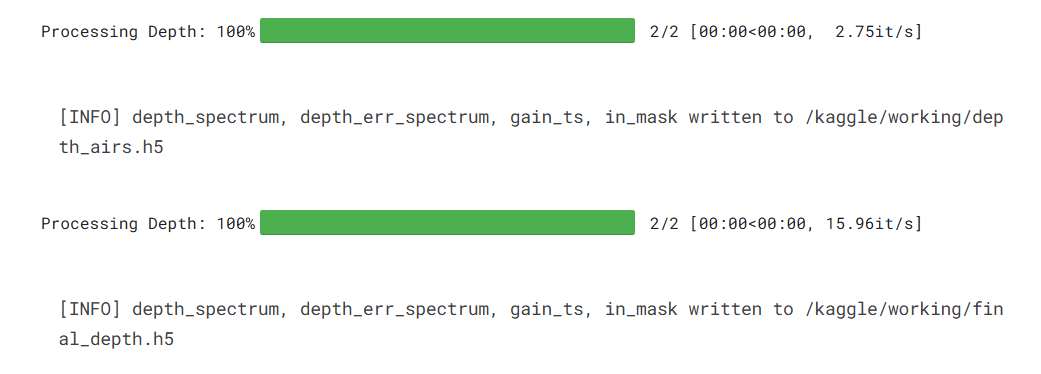

### Modelling

In [9]:
class NormalizeSignal:
    """Z-score normalize signal tensor per sample (on the fly)."""
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        mean = x.mean()
        std  = x.std()
        return (x - mean) / (std + 1e-6)


class NormalizeMeta:
    """Normalize metadata using fitted StandardScaler stats."""
    def __init__(self, scaler):
        self.mean  = torch.as_tensor(scaler.mean_,  dtype=torch.float32)
        self.scale = torch.as_tensor(scaler.scale_, dtype=torch.float32)

    def __call__(self, meta: torch.Tensor) -> torch.Tensor:
        return (meta - self.mean) / self.scale

    def inverse(self, meta_norm: torch.Tensor) -> torch.Tensor:
        return meta_norm * self.scale + self.mean


class NormalizeTargets:
    """Normalize targets using fitted StandardScaler stats."""
    def __init__(self, scaler):
        self.mean  = torch.as_tensor(scaler.mean_,  dtype=torch.float32)
        self.scale = torch.as_tensor(scaler.scale_, dtype=torch.float32)

    def __call__(self, y: torch.Tensor) -> torch.Tensor:
        return (y - self.mean) / self.scale

    # Inverse transforms (for μ and σ separately)
    def inv_mu(self, mu_norm: torch.Tensor) -> torch.Tensor:
        return mu_norm * self.scale + self.mean

    def inv_sigma(self, sigma_norm: torch.Tensor) -> torch.Tensor:
        return sigma_norm * self.scale

class NormalizeDepth:
    """Normalize depth spectra using fitted StandardScaler/RobustScaler stats."""
    def __init__(self, scaler):
        self.mean  = torch.as_tensor(scaler.center_,  dtype=torch.float32)
        self.scale = torch.as_tensor(scaler.scale_, dtype=torch.float32)

    def __call__(self, depth: torch.Tensor) -> torch.Tensor:
        return (depth - self.mean) / self.scale

    def inverse(self, depth_norm: torch.Tensor) -> torch.Tensor:
        return depth_norm * self.scale + self.mean

In [10]:
class ArielDataset(Dataset):
    def __init__(self, h5_file,
                 targets_df=None,
                 signal_transform=None,
                 meta_transform=None,
                 target_transform=None,
                 depth_transform_airs=None,
                 depth_transform_fgs=None,
                 shrink=True,
                 airs_size=(128, 256),
                 fgs_size=(128, 128),
                 depth_clip_airs=(-1e3, 1e4),   # clip range for airs depth (tune if needed)
                 depth_clip_fgs =(-1e4, 1e4)    # clip range for fgs depth
                 ):
        """
        h5_file: path to HDF5 containing AIRS, FGS, meta, planet_id and optional depth datasets.
        targets_df: DataFrame indexed by planet_id (required for training mode).
        """
        self.h5_file = h5_file
        self.targets_df = targets_df
        self.signal_transform = signal_transform
        self.meta_transform = meta_transform
        self.target_transform = target_transform
        self.depth_transform_airs = depth_transform_airs
        self.depth_transform_fgs  = depth_transform_fgs
        self.shrink = shrink
        self.airs_size = airs_size
        self.fgs_size  = fgs_size
        self.depth_clip_airs = depth_clip_airs
        self.depth_clip_fgs  = depth_clip_fgs

        with h5py.File(self.h5_file, "r", swmr=True, libver="latest") as f:
            if "AIRS" not in f:
                raise KeyError("AIRS dataset not found in HDF5.")
            self.length = int(f["AIRS"].shape[0])

            self.has_depth_airs = "airs_depth_spectrum" in f
            self.has_depth_fgs  = "fgs_depth_spectrum" in f

            # depth dims (target_nw) if present; else default to 283
            self.depth_dim_airs = int(f["airs_depth_spectrum"].shape[1]) if self.has_depth_airs else 283
            self.depth_dim_fgs  = int(f["fgs_depth_spectrum"].shape[1])  if self.has_depth_fgs  else 283

        # Note: targets_df must be indexed by planet_id (planet_id as index). If not, call:
        # targets_df = targets_df.set_index("planet_id") before passing it in.

    def __len__(self):
        return int(self.length)

    def __getitem__(self, idx):
        # Open once and read required arrays
        with h5py.File(self.h5_file, "r", swmr=True, libver="latest") as f:
            airs_np = np.array(f["AIRS"][idx], dtype=np.float32)   # (T, W)
            fgs_np  = np.array(f["FGS"][idx],  dtype=np.float32)
            meta_np = np.array(f["meta"][idx], dtype=np.float32)
            pid     = int(np.array(f["planet_id"][idx]))

            depth_airs_arr = np.array(f["airs_depth_spectrum"][idx], dtype=np.float32) if self.has_depth_airs else None
            depth_fgs_arr  = np.array(f["fgs_depth_spectrum"][idx], dtype=np.float32)  if self.has_depth_fgs  else None

        # convert signals to torch Tensors and optionally shrink (bilinear interpolation)
        airs = torch.from_numpy(airs_np).float()
        fgs  = torch.from_numpy(fgs_np).float()
        meta = torch.from_numpy(meta_np).float()

        if self.shrink:
            airs = F.interpolate(airs.unsqueeze(0).unsqueeze(0),
                                 size=self.airs_size, mode="bilinear", align_corners=False).squeeze(0).squeeze(0).contiguous()
            fgs  = F.interpolate(fgs.unsqueeze(0).unsqueeze(0),
                                 size=self.fgs_size, mode="bilinear", align_corners=False).squeeze(0).squeeze(0).contiguous()

        if self.signal_transform:
            airs = self.signal_transform(airs)
            fgs  = self.signal_transform(fgs)
        if self.meta_transform:
            meta = self.meta_transform(meta)

        # handle depth arrays: fallback to zeros if missing
        if depth_airs_arr is None:
            depth_airs_arr = np.zeros(self.depth_dim_airs, dtype=np.float32)
        if depth_fgs_arr is None:
            depth_fgs_arr = np.zeros(self.depth_dim_fgs, dtype=np.float32)

        # robustify / clip extreme outliers (important given your stats)
        lo_a, hi_a = self.depth_clip_airs
        lo_f, hi_f = self.depth_clip_fgs
        depth_airs_arr = np.clip(depth_airs_arr, lo_a, hi_a).astype(np.float32)
        depth_fgs_arr  = np.clip(depth_fgs_arr,  lo_f, hi_f).astype(np.float32)

                # robustify / clip extreme outliers (important given your stats)
        lo_a, hi_a = self.depth_clip_airs
        lo_f, hi_f = self.depth_clip_fgs
        depth_airs_arr = np.clip(depth_airs_arr, lo_a, hi_a).astype(np.float32)
        depth_fgs_arr  = np.clip(depth_fgs_arr,  lo_f, hi_f).astype(np.float32)

        if self.depth_transform_airs is not None:
            try:
                depth_airs_arr = self.depth_transform_airs(depth_airs_arr)
                if isinstance(depth_airs_arr, torch.Tensor):
                    depth_airs_arr = depth_airs_arr.detach().cpu().numpy().astype(np.float32)
            except Exception:
                depth_airs_t_tmp = torch.from_numpy(depth_airs_arr).float()
                depth_airs_t_tmp = self.depth_transform_airs(depth_airs_t_tmp)
                depth_airs_arr = depth_airs_t_tmp.detach().cpu().numpy().astype(np.float32)

        if self.depth_transform_fgs is not None:
            try:
                depth_fgs_arr = self.depth_transform_fgs(depth_fgs_arr)
                if isinstance(depth_fgs_arr, torch.Tensor):
                    depth_fgs_arr = depth_fgs_arr.detach().cpu().numpy().astype(np.float32)
            except Exception:
                depth_fgs_t_tmp = torch.from_numpy(depth_fgs_arr).float()
                depth_fgs_t_tmp = self.depth_transform_fgs(depth_fgs_t_tmp)
                depth_fgs_arr = depth_fgs_t_tmp.detach().cpu().numpy().astype(np.float32)

        depth_airs_t = torch.from_numpy(depth_airs_arr).float()
        depth_fgs_t  = torch.from_numpy(depth_fgs_arr).float()

        # targets (optional)
        if self.targets_df is not None:
            # expect targets_df indexed by planet_id
            try:
                y_np = self.targets_df.loc[pid].to_numpy(dtype=np.float32)
            except Exception as e:
                raise KeyError(f"planet_id {pid} not found in targets_df index. Make sure targets_df is indexed by planet_id.") from e
            y = torch.from_numpy(y_np)
            if self.target_transform:
                y = self.target_transform(y)
            return (airs, fgs, meta, depth_airs_t, depth_fgs_t), y, pid

        return (airs, fgs, meta, depth_airs_t, depth_fgs_t), pid

In [ ]:
final_processed_file = '/kaggle/working/final_depth.h5' 
test_dataset = ArielDataset(final_processed_file, targets_df=None, signal_transform=NormalizeSignal(), meta_transform=NormalizeMeta(meta_scaler), target_transform=None, 
                            depth_transform_airs=NormalizeDepth(depth_scaler_airs),
                            depth_transform_fgs=NormalizeDepth(depth_scaler_fgs),
                            shrink=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=0, pin_memory=True)
Modelling
def gaussian_nll(y, mu, sigma, mask=None, eps=1e-8):
    """
    y, mu, sigma: [B, D]
    mask: optional boolean mask [B, D] for missing targets
    returns mean NLL over unmasked elements
    """
    const = -0.5 * math.log(2 * math.pi)
    logp = const - torch.log(sigma + eps) - 0.5 * ((y - mu) / (sigma + eps))**2
    nll = -logp  # [B, D]
    if mask is not None:
        # mask should be boolean; flatten and select
        mask = mask.bool()
        if mask.dim() != nll.dim():
            raise ValueError("mask must have same shape as y/mu/sigma")
        nll = nll[mask]
        if nll.numel() == 0:
            return torch.tensor(0.0, device=y.device)
        return nll.mean()
    return nll.mean()

@torch.no_grad()
def coverage_at(y, mu, sigma, p=0.68):
    """
    Coverage assuming Gaussian predictive intervals.
    Returns observed fraction within +/- z * sigma.
    """
    # compute z for given p robustly using torch.erfinv: z = sqrt(2) * erfinv(p)
    # For central interval p, one-sided tail probability = (1+p)/2
    one_sided = (1.0 + p) / 2.0
    # inverse CDF of standard normal: z = sqrt(2) * erfinv(2*one_sided - 1)
    z = (2 ** 0.5) * torch.erfinv(torch.tensor(2.0 * one_sided - 1.0, device=mu.device, dtype=mu.dtype))
    inside = (torch.abs(y - mu) <= (z * sigma))
    return float(inside.float().mean().item())

In [11]:
class Conv2dBlock(nn.Module):
    def __init__(self, c_in, c_out, stride=2):
        super().__init__()
        self.conv = nn.Conv2d(c_in, c_out, 3, stride=stride, padding=1)
        self.gn   = nn.GroupNorm(num_groups=max(1, min(8, c_out//4)), num_channels=c_out)
        self.act  = nn.ReLU(inplace=True)
        mid = max(16, c_out//16)
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(c_out, mid, 1), nn.ReLU(inplace=True),
            nn.Conv2d(mid, c_out, 1), nn.Sigmoid()
        )
    def forward(self, x):
        x = self.conv(x); x = self.gn(x); x = self.act(x)
        return x * self.se(x)

class Small2DEncoder(nn.Module):
    def __init__(self, in_ch=1, base=16, out_dim=256, last_stride=2):
        super().__init__()
        self.b1 = Conv2dBlock(in_ch, base,    stride=2)
        self.b2 = Conv2dBlock(base, base*2,   stride=2)
        self.b3 = Conv2dBlock(base*2, base*4, stride=2)
        self.b4 = Conv2dBlock(base*4, base*8, stride=last_stride)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc   = nn.Linear(base*8, out_dim)
        self.out_dim = out_dim
    
    def forward(self, x):            # x: [B,1,T,W]
        x = self.b1(x); x = self.b2(x); x = self.b3(x); x = self.b4(x)
        x = self.pool(x).flatten(1)  # [B, base*4]
        return self.fc(x)            # [B, out_dim]

class CrossGate(nn.Module):
    def __init__(self, d=256, r=4):
        super().__init__()
        h = max(d//r, 32)
        self.fa = nn.Sequential(nn.Linear(d, h), nn.ReLU(), nn.Linear(h, d), nn.Sigmoid())
        self.ff = nn.Sequential(nn.Linear(d, h), nn.ReLU(), nn.Linear(h, d), nn.Sigmoid())
    def forward(self, a, f):
        return torch.cat([a * self.fa(f), f * self.ff(a)], dim=-1)

class SimpleCrossAttention(nn.Module):
    def __init__(self, dim, hidden_dim=None):
        super().__init__()
        hidden_dim = hidden_dim or dim
        self.q_proj = nn.Linear(dim, hidden_dim)
        self.k_proj = nn.Linear(dim, hidden_dim)
        self.v_proj = nn.Linear(dim, hidden_dim)
        self.out_proj = nn.Linear(hidden_dim, dim)

    def forward(self, a, f):
        # a, f: [B, D]
        q = self.q_proj(a).unsqueeze(1)
        k = self.k_proj(f).unsqueeze(1)
        v = self.v_proj(f).unsqueeze(1)

        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / (q.size(-1) ** 0.5)  # [B,1,1]
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attended = torch.matmul(attn_weights, v).squeeze(1)  # [B, H]

        return self.out_proj(attended)

class HeteroGaussianHead(nn.Module):
    def __init__(self, in_dim, out_dim, drop=0.3, sigma_floor=1e-3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 512), nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(512, out_dim*2)
        )
        self.out_dim = out_dim
        self.register_buffer("sigma_floor", torch.tensor(sigma_floor, dtype=torch.float32))
    def forward(self, x):
        B = x.size(0)
        raw = self.net(x).view(B, self.out_dim, 2)
        mu, log_sigma = raw[...,0], raw[...,1]
        sigma = F.softplus(log_sigma) + self.sigma_floor
        return mu, sigma

In [12]:
class ArielHG2D(nn.Module):
    def __init__(self,
                 out_dim=283,
                 base=16,
                 enc_dim=256,
                 meta_dim=8,
                 meta_hidden=128,
                 last_stride=2,
                 attention=False,
                 depth_dim_airs=283,
                 depth_dim_fgs=283,
                 depth_emb_dim=64,
                 fusion_hidden=256,
                 dropout=0.1,
                 init_log_sigma=-4.0):
        """
        Adapted ArielHG2D that matches your Small2DEncoder, CrossGate, SimpleCrossAttention,
        and HeteroGaussianHead implementations.
        """
        super().__init__()
        self.attention = attention
        self.out_dim = out_dim
        self.eps = 1e-6
        self.init_log_sigma = float(init_log_sigma)

        # image encoders (reuse your Small2DEncoder)
        self.airs = Small2DEncoder(in_ch=1, base=base, out_dim=enc_dim, last_stride=last_stride)
        self.fgs  = Small2DEncoder(in_ch=1, base=base, out_dim=enc_dim, last_stride=last_stride)

        # cross attention or gate
        if self.attention:
            self.attn_af = SimpleCrossAttention(dim=enc_dim)
            self.attn_fa = SimpleCrossAttention(dim=enc_dim)
        else:
            self.gate = CrossGate(d=enc_dim, r=4)

        # meta branch
        self.meta = nn.Sequential(
            nn.Linear(meta_dim, meta_hidden),
            nn.ReLU(inplace=True),
            nn.LayerNorm(meta_hidden)
        )

        # depth encoders: conv1d -> pool -> linear -> LayerNorm
        def make_depth_encoder(in_len, emb_dim):
            return nn.Sequential(
                nn.Conv1d(1, 16, kernel_size=5, padding=2),
                nn.ReLU(inplace=True),
                nn.Conv1d(16, 32, kernel_size=5, padding=2),
                nn.ReLU(inplace=True),
                nn.AdaptiveAvgPool1d(1),
                nn.Flatten(),
                nn.Linear(32, emb_dim),
                nn.ReLU(inplace=True),
                nn.LayerNorm(emb_dim)
            )

        self.depth_enc_airs = make_depth_encoder(depth_dim_airs, depth_emb_dim)
        self.depth_enc_fgs  = make_depth_encoder(depth_dim_fgs, depth_emb_dim)

        # compute image feature dim (concatenated a & f)
        image_feat_dim = self.airs.out_dim + self.fgs.out_dim    # typically 2*enc_dim

        combined_meta_dim = meta_hidden + depth_emb_dim + depth_emb_dim

        # FiLM mapping from combined meta -> gamma,beta sized to image_feat_dim
        self.film = nn.Linear(combined_meta_dim, image_feat_dim * 2)

        # fusion MLP (LayerNorm + Dropout for stability)
        self.fusion_mlp = nn.Sequential(
            nn.Linear(image_feat_dim, fusion_hidden),
            nn.ReLU(inplace=True),
            nn.LayerNorm(fusion_hidden),
            nn.Dropout(dropout),
            nn.Linear(fusion_hidden, fusion_hidden // 2),
            nn.ReLU(inplace=True),
            nn.LayerNorm(fusion_hidden // 2),
            nn.Dropout(dropout),
        )

        # use your HeteroGaussianHead; it expects in_dim and out_dim
        head_in = fusion_hidden // 2
        self.head = HeteroGaussianHead(in_dim=head_in, out_dim=out_dim, drop=0.3, sigma_floor=1e-6)

        # initialize head's log-sigma bias to init_log_sigma
        # HeteroGaussianHead.net final linear has out_features == out_dim*2 and bias layout [mu_bias..., logsigma_bias...]
        final_linear = None
        # locate the final linear layer in HeteroGaussianHead.net
        for m in self.head.net.modules():
            if isinstance(m, nn.Linear) and m.out_features == out_dim * 2:
                final_linear = m
        if final_linear is not None:
            with torch.no_grad():
                # set log-sigma bias (second half) to init_log_sigma
                b = final_linear.bias
                b.data[out_dim:] = self.init_log_sigma
        else:
            # fallback: nothing to init (shouldn't happen)
            pass

        # save attributes
        self.depth_dim_airs = depth_dim_airs
        self.depth_dim_fgs  = depth_dim_fgs
        self.depth_emb_dim  = depth_emb_dim
        self.fusion_hidden = fusion_hidden

    def forward(self, airs, fgs, meta, depth_airs=None, depth_fgs=None):
        """
        airs: [B, T, W]  (before unsqueeze to channel)
        fgs:  [B, T, W]
        meta: [B, meta_dim]
        depth_airs: [B, L] or None
        depth_fgs:  [B, L] or None
        """
        device = meta.device if meta is not None else airs.device

        airs = airs.unsqueeze(1)   # [B,1,T,W]
        fgs  = fgs.unsqueeze(1)

        a = self.airs(airs)  # [B, enc_dim]
        f = self.fgs(fgs)    # [B, enc_dim]
        m = self.meta(meta)  # [B, meta_hidden]

        if self.attention:
            a_attended = a + self.attn_af(a, f)
            f_attended = f + self.attn_fa(f, a)
            image_feat = torch.cat([a_attended, f_attended], dim=-1)
        else:
            image_feat = self.gate(a, f)  # expected shape [B, 2*enc_dim]

        bsz = meta.size(0)
        if depth_airs is None:
            depth_airs = torch.zeros(bsz, self.depth_dim_airs, dtype=torch.float32, device=device)
        if depth_fgs is None:
            depth_fgs = torch.zeros(bsz, self.depth_dim_fgs, dtype=torch.float32, device=device)

        depth_airs_emb = self.depth_enc_airs(depth_airs.unsqueeze(1))
        depth_fgs_emb  = self.depth_enc_fgs(depth_fgs.unsqueeze(1))

        combined_meta = torch.cat([m, depth_airs_emb, depth_fgs_emb], dim=-1)

        # FiLM
        gamma_beta = self.film(combined_meta)
        gamma, beta = gamma_beta.chunk(2, dim=-1)
        image_feat = image_feat * (1.0 + gamma) + beta

        x = self.fusion_mlp(image_feat)

        mu, sigma = self.head(x)   # HeteroGaussianHead returns (mu, sigma) with softplus + floor

        return mu, sigma

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = ArielHG2D(out_dim=283, base=64, enc_dim=512, meta_dim=8, meta_hidden=128, last_stride=2, attention=False, 
                  depth_dim_airs=283,
                depth_dim_fgs=283,
                depth_emb_dim=64,
                fusion_hidden=256
).to(device)

# load checkpoint (works whether you saved dict or raw state_dict)
ckpt = torch.load(model_path, map_location=device)
if isinstance(ckpt, dict) and "model" in ckpt:
    state_dict = ckpt["model"]
else:
    state_dict = ckpt
model.load_state_dict(state_dict)
model.eval()

preds = []

with torch.no_grad():
    for features, pid in tqdm(test_loader, desc="Submission Inference"):
        print(pid)
        airs, fgs, metas, depth_airs, depth_fgs = features
        airs = airs.to(device, non_blocking=True)
        fgs = fgs.to(device, non_blocking=True)
        metas = metas.to(device, non_blocking=True)
        depth_airs = depth_airs.to(device, non_blocking=True)
        depth_fgs  = depth_fgs.to(device, non_blocking=True)
        
        with torch.cuda.amp.autocast():
            mu, sigma = model(airs, fgs, metas, depth_airs, depth_fgs)

        mu, sigma = mu.cpu().numpy(), sigma.cpu().numpy()
        mu = y_scaler.inverse_transform(mu)
        sigma = sigma * y_scaler.scale_

        for p, m, s in zip(pid, mu, sigma):
            preds.append([int(p)] + list(m) + list(s))

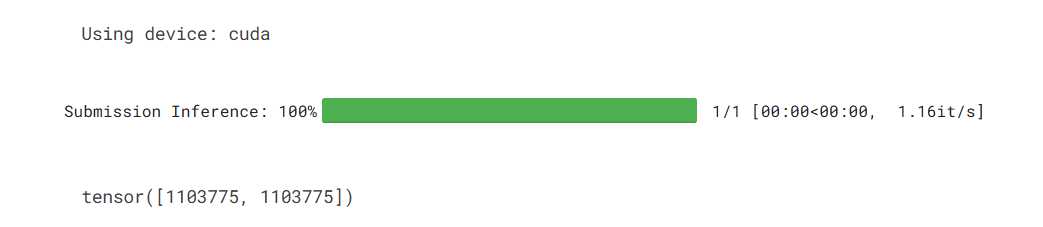

In [ ]:
num_wl = mu.shape[1]
num_sigma = sigma.shape[1]
wl_cols = [f"wl_{i+1}" for i in range(num_wl)]
sigma_cols = [f"sigma_{i+1}" for i in range(num_sigma)]

# Convert tensors to scalars
preds_np = np.array([
    [v.item() if isinstance(v, torch.Tensor) else v for v in row]
    for row in preds
])

cols = ["planet_id"] + wl_cols + sigma_cols
submission = pd.DataFrame(preds_np, columns=cols)

submission['planet_id'] = submission['planet_id'].astype(int)

def collapse_duplicates(df, method="inv_var", eps=1e-6):
    """
    method: "inv_var" or "mean"
    eps: small stabilizer to avoid div-by-zero
    """
    if not df['planet_id'].duplicated().any():
        print("[INFO] No duplicates found.")
        return df.sort_values('planet_id').reset_index(drop=True)

    groups = []
    gby = df.groupby('planet_id')
    for pid, g in gby:
        mu_vals = g[wl_cols].values      # shape (k, num_wl)
        sigma_vals = g[sigma_cols].values  # shape (k, num_sigma)
        if method == "inv_var":
            var = np.maximum(sigma_vals**2, eps)
            # if sigma and wl count differ, broadcast smallest axis (usual case: same count)
            weighted_mu = np.sum(mu_vals / var, axis=0) / np.sum(1.0 / var, axis=0)
            combined_var = 1.0 / np.sum(1.0 / var, axis=0)
            combined_sigma = np.sqrt(np.maximum(combined_var, eps))
            row = [int(pid)] + weighted_mu.tolist() + combined_sigma.tolist()
        else:  # simple mean
            row_mu = mu_vals.mean(axis=0)
            row_sigma = sigma_vals.mean(axis=0)
            row = [int(pid)] + row_mu.tolist() + row_sigma.tolist()
        groups.append(row)
    out = pd.DataFrame(groups, columns=cols)
    print(f"[INFO] Collapsed {df['planet_id'].nunique()} unique ids from {len(df)} rows using method='{method}'.")
    return out.sort_values('planet_id').reset_index(drop=True)

# Choose method: "inv_var" (recommended if sigma is predictive std) or "mean"
submission_clean = collapse_duplicates(submission, method="inv_var")

submission_clean.to_csv("submission.csv", index=False)
print("[INFO] Submission saved to submission.csv (rows: {})".format(len(submission_clean)))

In [ ]:
submission_clean.head()

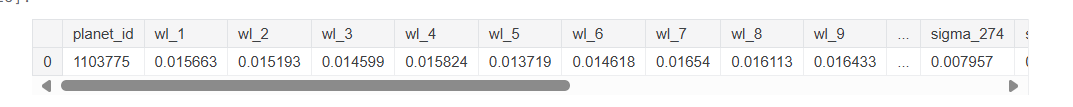

In [13]:
class ParticipantVisibleError(Exception):
    pass

def score(
    solution: pd.DataFrame,
    submission: pd.DataFrame,
    row_id_column_name: str,
    naive_mean: float,
    naive_sigma: float,
    fsg_sigma_true: float = 1e-6,
    airs_sigma_true: float = 1e-5,
    fgs_weight: float = 1,
) -> float:
    """
    This is a Gaussian Log Likelihood based metric. For a submission, which contains the predicted mean (x_hat) and variance (x_hat_std),
    we calculate the Gaussian Log-likelihood (GLL) value to the provided ground truth (x). We treat each pair of x_hat,
    x_hat_std as a 1D gaussian, meaning there will be 283 1D gaussian distributions, hence 283 values for each test spectrum,
    the GLL value for one spectrum is the sum of all of them.

    Inputs:
        - solution: Ground Truth spectra (from test set)
            - shape: (nsamples, n_wavelengths)
        - submission: Predicted spectra and errors (from participants)
            - shape: (nsamples, n_wavelengths*2)
        naive_mean: (float) mean from the train set.
        naive_sigma: (float) standard deviation from the train set.
        fsg_sigma_true: (float) standard deviation from the FSG1 instrument for the test set.
        airs_sigma_true: (float) standard deviation from the AIRS instrument for the test set.
        fgs_weight: (float) relative weight of the fgs channel
    """

    del solution[row_id_column_name]
    del submission[row_id_column_name]

    if submission.min().min() < 0:
        raise ParticipantVisibleError('Negative values in the submission')
    for col in submission.columns:
        if not pd.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f'Submission column {col} must be a number')

    n_wavelengths = len(solution.columns)
    if len(submission.columns) != n_wavelengths * 2:
        raise ParticipantVisibleError('Wrong number of columns in the submission')

    y_pred = submission.iloc[:, :n_wavelengths].values
    # Set a non-zero minimum sigma pred to prevent division by zero errors.
    sigma_pred = np.clip(submission.iloc[:, n_wavelengths:].values, a_min=10**-15, a_max=None)
    sigma_true = np.append(
        np.array(
            [
                fsg_sigma_true,
            ]
        ),
        np.ones(n_wavelengths - 1) * airs_sigma_true,
    )
    y_true = solution.values

    GLL_pred = scipy.stats.norm.logpdf(y_true, loc=y_pred, scale=sigma_pred)
    GLL_true = scipy.stats.norm.logpdf(y_true, loc=y_true, scale=sigma_true * np.ones_like(y_true))
    GLL_mean = scipy.stats.norm.logpdf(y_true, loc=naive_mean * np.ones_like(y_true), scale=naive_sigma * np.ones_like(y_true))

    # normalise the score, right now it becomes a matrix instead of a scalar.
    ind_scores = (GLL_pred - GLL_mean) / (GLL_true - GLL_mean)

    weights = np.append(np.array([fgs_weight]), np.ones(len(solution.columns) - 1))
    weights = weights * np.ones_like(ind_scores)
    submit_score = np.average(ind_scores, weights=weights)
    return float(np.clip(submit_score, 0.0, 1.0))

Link to the notebook

https://www.kaggle.com/code/rathorevedant99/ariel-submission